In [1]:
import numpy as np
import time
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

In [2]:
def create_starting_optic(thick,R,k=-1,N=100):
    z=np.linspace(0,thick,N) #solves the problem of not having enough points close to the origin
    r=np.sqrt(2*R*z-(k+1)*z**2) 
    optic=np.array([z,r])
    return optic

In [3]:
def find_local_eq(r,optic,N=100):
    # first find nearest point in the lens array to where the ray r intersects
    z=optic[0]
    opt=optic[1]
    index=np.abs(opt-r).argmin()
    
    # isolate a few points around the closest index (look into how many points we actually want)
    lower=index-2 if index-3>0 else 0
    upper=index+2
        
    local_z=np.array(z[lower:upper])
    local_opt=np.array(opt[lower:upper])-r
    
    local_z=local_z[::-1]
    local_opt=-1*local_opt[::-1]
    # Use cubic spline to interpolate the local points
    # need to switch the z and the r coordinates so that cubic spline won't give error
    cs=None
    try:
        cs=CubicSpline(local_opt,local_z)
    except:
        print(local_opt)
        print(lower)
        print(upper)
    #zs=np.linspace(local_z[0],local_z[-1],N) 
    return cs

In [4]:
def find_reflect_slope(norm):
    theta=np.arctan(norm)
    slope=np.tan(2*theta)
    return slope

In [5]:
def raytrace(optic, exp_f, Nr=7, linsp=True):
    #create the starting rays
    opt=optic[1]
    # make sure that the rays are bounded 
    r_min=opt[4]
    r_max=opt[-5]
    
    rays=np.linspace(r_min,r_max,Nr) if linsp else np.geomspace(r_min,r_max,Nr) #confine the rays to the diameter of the optic
    rays[rays==0]=1e-9 # if r=0 exists set to small value so we don't get infinity values
    raymatrix=[] # 3 points: before, at, after the optic
    after=[]
    for r in rays:
        cs=find_local_eq(r,optic)
        z_optic=cs(0)        
        norm=cs(0,1) #The normal is just the derivative 
        slope=find_reflect_slope(norm)
        r_after=slope*(exp_f-z_optic)+r # This is where the ray meets z=exp_f
        z_bef=exp_f*1.5 # change this so that z_bef all starts at the same z value
        z_ray=[z_bef,z_optic,exp_f]
        r_ray=[r,r,r_after]            
        raymatrix.append([z_ray,r_ray])
        after.append(r_after)
        #np.concatenate(raymatrix)
    return np.array(raymatrix),np.array(after)

In [6]:
def plot(optic,raymatrix,exp_f,title=None, lambda0=None, norm=False,savefig=False):
    #first plot the optic:
    plt.figure(figsize=(15,10))
    opt_z=optic[0] if not norm else optic[0]/lambda0
    opt_r=optic[1] if not norm else optic[1]/lambda0
    plt.plot(opt_z,opt_r,'b',opt_z,-1*opt_r,'b')
    exp_freq=exp_f if not norm else exp_f/lambda0
    plt.axvline(x=exp_freq, color='k', linestyle='--')
    #Then plot the rays:
    for ray in raymatrix:
        ray_z=ray[0] if not norm else ray[0]/lambda0
        ray_r=ray[1] if not norm else ray[1]/lambda0
        plt.plot(ray_z[1],ray_r[1],'r',ray_z,-1*ray_r,'r')
        
    xl='z (m)' if not norm else 'z/lambda'
    yl='r (m)' if not norm else 'r/lambda'
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.xlim((-0.01,exp_f+0.02))
    r_max=max(opt_r)+0.02
    plt.ylim((-r_max,r_max))
    if savefig:
        plt.savefig(title+".png")
    #plt.show()
    plt.close()

In [7]:
def rms(rays_after):
    n=len(rays_after)
    return np.sqrt(np.sum(rays_after**2)/n)

In [8]:
def grad(i,epsilon,optic,signs,exp_f,Nr):
    o_z=optic[0]
    o=optic[1]
    j=i+1
    o_z[j]+=signs[i]*epsilon
    a=np.copy(o_z)
    rm1,af1=raytrace([o_z,o],exp_f,Nr)
    o_z[j]-=2*signs[i]*epsilon
    b=np.copy(o_z)
    rm2,af2=raytrace([o_z,o],exp_f,Nr)
    c1=rms(af1)
    c2=rms(af2)
    return np.abs(c1-c2)

In [9]:
def gradient_descent(epsilon,dz,start_k,thick,roc,exp_f,learn_rate,n_iter=1000,tol=1e-6,No=100,Nr=1000,plt=False,title=None):
    start_o=create_starting_optic(thick,roc,k=start_k,N=No)
    o_r=start_o[1]
    os=[start_o[0]]
    rm0,af0=raytrace(start_o,exp_f,Nr)
    cost=[rms(af0)]
    n=0
    if plt:
        plot(start_o,rm0,exp_f,title+"_%d"%(n),savefig=True)
    diff=1e6
    dzs=np.ones(No-1)*dz
    cdz=np.array(dzs)
    #print(dzs)
    print('Step: %d\t Cost: %f'%(n,cost[0]))
    o=start_o[0]
    grads=[]
    while(n<n_iter and abs(diff)>tol):
        #print(change_dzs)
        start_time=time.time()
        n+=1
        signs=np.random.choice([-1,1],No-1)
        o[1:]+=signs*dzs #move each point in the optic randomly by dz except for the point at origin
        os.append(o)
        rm,af=raytrace([o,o_r],exp_f,Nr)
        c=rms(af)
        cost.append(c)
        gs=[]
        if plt:
            plot([o,o_r],rm,exp_f,title+"_%d"%(n),savefig=True)
        for i in range(len(dzs)):
            g=grad(i,epsilon,[o,o_r],signs,exp_f,Nr)
            gs.append(g)
            step_size=learn_rate*signs[i]*g
            dzs[i]+=step_size
        diff=c
        grads.append(gs)
        cdz=np.vstack([cdz,dzs])
        #print(dzs)
        print('Step:%d\t Cost: %f \t diff: %E \t time: %s'%(n,c,diff,time.time()-start_time))
    return os,o_r,cost,cdz,grads

In [36]:
o,o_r,c,cdz,g=gradient_descent(1e-7,5e-7,-0.8,0.0064,0.1125,0.05625,1e-4,n_iter=100,Nr=20,plt=True,title='../testing/step')

Step: 0	 Cost: 0.000208
Step:1	 Cost: 0.000367 	 diff: 3.666937E-04 	 time: 0.8043549060821533
Step:2	 Cost: 0.000334 	 diff: 3.339851E-04 	 time: 0.7863190174102783
Step:3	 Cost: 0.000480 	 diff: 4.799841E-04 	 time: 0.7904388904571533
Step:4	 Cost: 0.000516 	 diff: 5.159955E-04 	 time: 0.7840011119842529
Step:5	 Cost: 0.000652 	 diff: 6.524294E-04 	 time: 0.7800710201263428
Step:6	 Cost: 0.000579 	 diff: 5.789030E-04 	 time: 0.7743229866027832
Step:7	 Cost: 0.000585 	 diff: 5.854539E-04 	 time: 0.8175549507141113
Step:8	 Cost: 0.000595 	 diff: 5.950766E-04 	 time: 0.771259069442749
Step:9	 Cost: 0.000649 	 diff: 6.492340E-04 	 time: 0.780919075012207
Step:10	 Cost: 0.000574 	 diff: 5.740952E-04 	 time: 0.789297342300415
Step:11	 Cost: 0.000616 	 diff: 6.158207E-04 	 time: 0.774090051651001
Step:12	 Cost: 0.000657 	 diff: 6.568792E-04 	 time: 0.7773549556732178
Step:13	 Cost: 0.000669 	 diff: 6.689494E-04 	 time: 0.7885150909423828
Step:14	 Cost: 0.000735 	 diff: 7.350926E-04 	 time: 

In [67]:
for i in range(100)[::9]:
    print(i)

0
9
18
27
36
45
54
63
72
81
90
99


ValueError: alpha (1.8) is outside 0-1 range

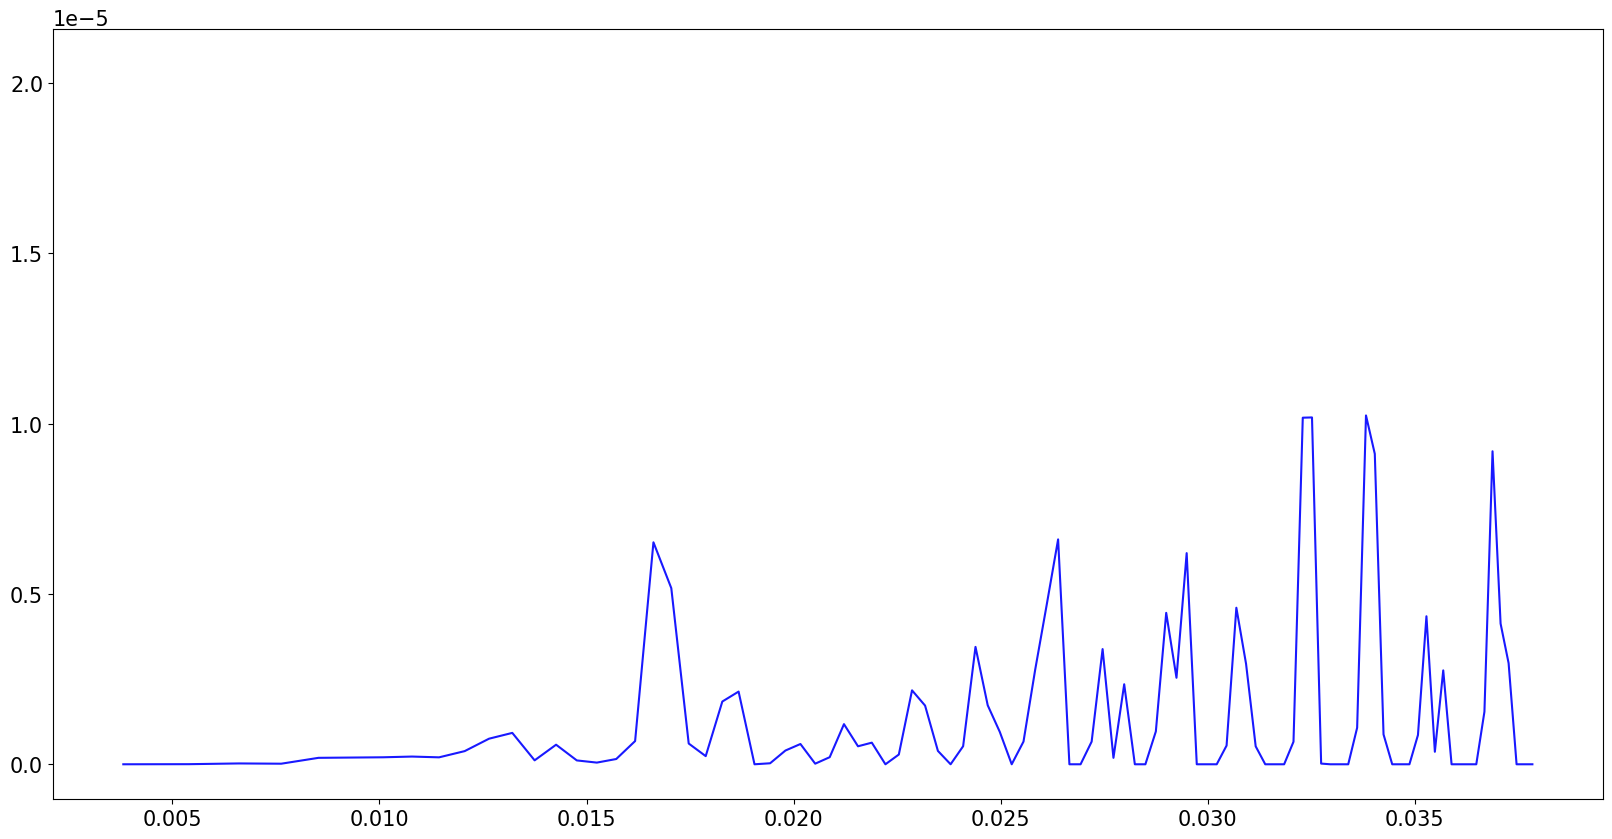

In [68]:
fig,ax=plt.subplots(figsize=(20,10))
for i in range(100)[::9]:
    ax.plot(o_r[1:],g[i],c='b',alpha=0.1*(i),label="step %d"%(i+1))
    
# ax.legend(bbox_to_anchor=(1.04,1),loc='upper left',ncol=3,prop={'size':10})
ax.legend(bbox_to_anchor=(1.04,1),loc='upper left')


rs=np.linspace(o_r[4],o_r[-5],20)
for r in rs:
    ax.axvline(x=r,c='k',linestyle='--')

ax.set_title('Gradient value for first 100 steps with 20 rays')
ax.set_xlabel('r (m)')
ax.set_ylabel('gradient')

plt.tight_layout()
plt.savefig('grad_steps-100_cs_2_r-20-10')
plt.show()
    

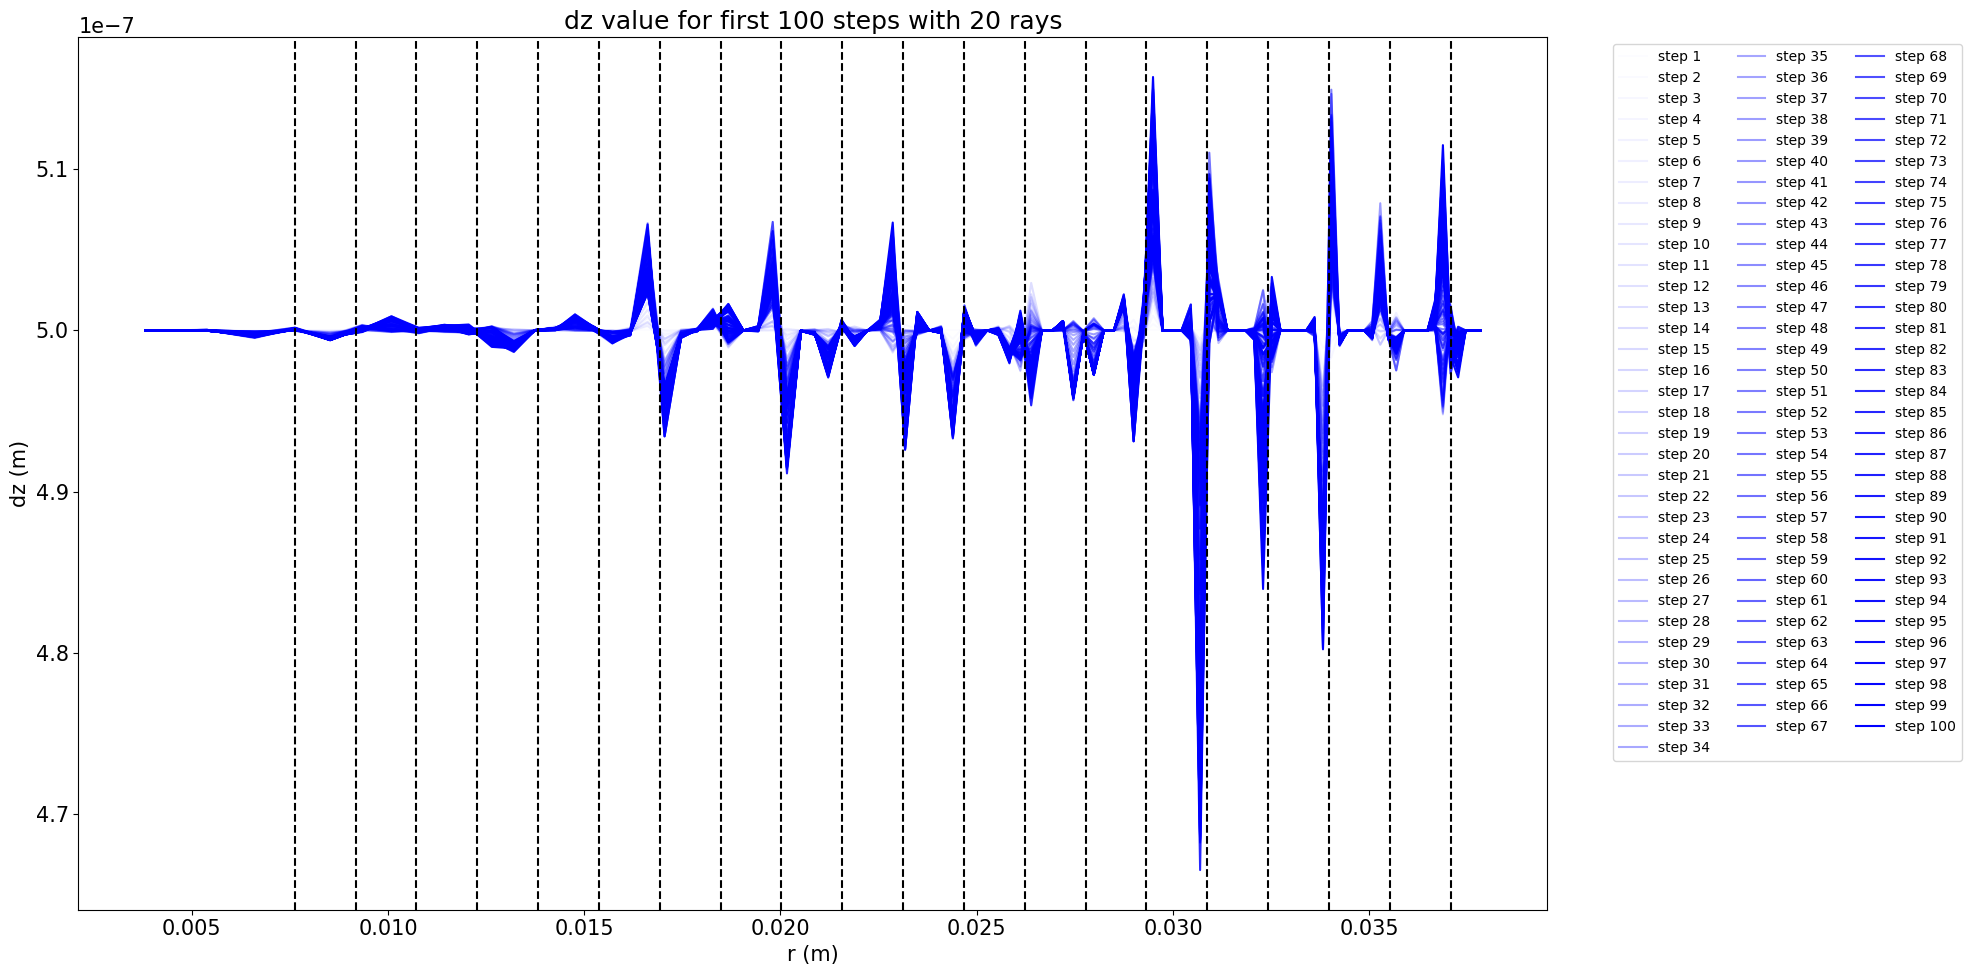

In [61]:
fig,ax=plt.subplots(figsize=(20,10))

for i in range(100)[::10]:
    ax.plot(o_r[1:],cdz[i],c='b',alpha=0.1*(i+1),label="step %d"%(i+1))


for r in rs:
    ax.axvline(x=r,c='k',linestyle='--')


ax.set_title('dz value for first 100 steps with 20 rays')
ax.set_xlabel('r (m)')
ax.set_ylabel('dz (m)')


ax.legend(bbox_to_anchor=(1.04,1),loc='upper left',ncol=3,prop={'size':10})

plt.tight_layout()
plt.savefig('dz_steps-100_cs-2_r-20-10')


plt.show()
    

In [60]:
start_o = create_starting_optic(0.0064,0.1125,k=-0.95,N=100)
sor=np.copy(start_o[1])
rm0,af0=raytrace(start_o,0.05625,100)
cost=rms(af0)

In [31]:
cost

4.96339361057736e-05

In [11]:
soz=np.copy(start_o[0])
signs=np.random.choice([-1,1],99)
dz=signs*5e-7
soz[1:]+=dz
print(soz)

[0.00000000e+00 6.41464646e-05 1.29792929e-04 1.93439394e-04
 2.58085859e-04 3.23732323e-04 3.88378788e-04 4.53025253e-04
 5.17671717e-04 5.82318182e-04 6.45964646e-04 7.11611111e-04
 7.76257576e-04 8.39904040e-04 9.04550505e-04 9.69196970e-04
 1.03484343e-03 1.09848990e-03 1.16413636e-03 1.22778283e-03
 1.29342929e-03 1.35707576e-03 1.42272222e-03 1.48636869e-03
 1.55101515e-03 1.61566162e-03 1.68030808e-03 1.74595455e-03
 1.81060101e-03 1.87524747e-03 1.93889394e-03 2.00454040e-03
 2.06918687e-03 2.13383333e-03 2.19747980e-03 2.26212626e-03
 2.32677273e-03 2.39141919e-03 2.45606566e-03 2.52171212e-03
 2.58635859e-03 2.65000505e-03 2.71565152e-03 2.77929798e-03
 2.84394444e-03 2.90859091e-03 2.97323737e-03 3.03888384e-03
 3.10253030e-03 3.16817677e-03 3.23182323e-03 3.29646970e-03
 3.36211616e-03 3.42676263e-03 3.49140909e-03 3.55505556e-03
 3.61970202e-03 3.68534848e-03 3.74999495e-03 3.81364141e-03
 3.87928788e-03 3.94393434e-03 4.00858081e-03 4.07222727e-03
 4.13787374e-03 4.202520

In [12]:
g0=[]
g1=[]
for i in range(len(dz)):
    g0.append(grad(i,1e-7,start_o,signs,0.05625,100))
    g1.append(grad(i,1e-7,[soz,sor],signs,0.05625,100))

In [13]:
r=np.linspace(0,0.0375,100)
R=0.1125
z08=r**2/(R+np.sqrt(R**2-(1-0.8)*r**2))
z1=r**2/(R+np.sqrt(R**2-(1-1)*r**2))

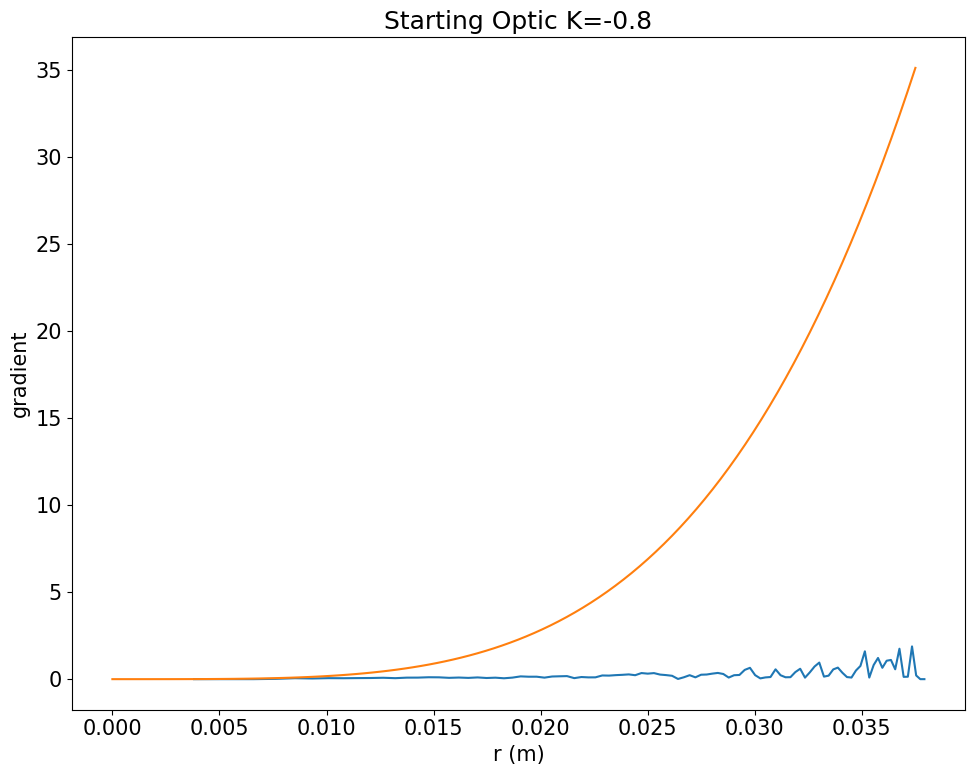

In [32]:
plt.figure(figsize=(10,8))
plt.plot(sor[1:],np.abs(g0)/1e-6)
plt.plot(r,(z08-z1)/1e-6)
plt.xlabel('r (m)')
plt.ylabel('gradient')
plt.title("Starting Optic K=-0.8")
plt.tight_layout()
#plt.savefig('so_norm')
plt.show()

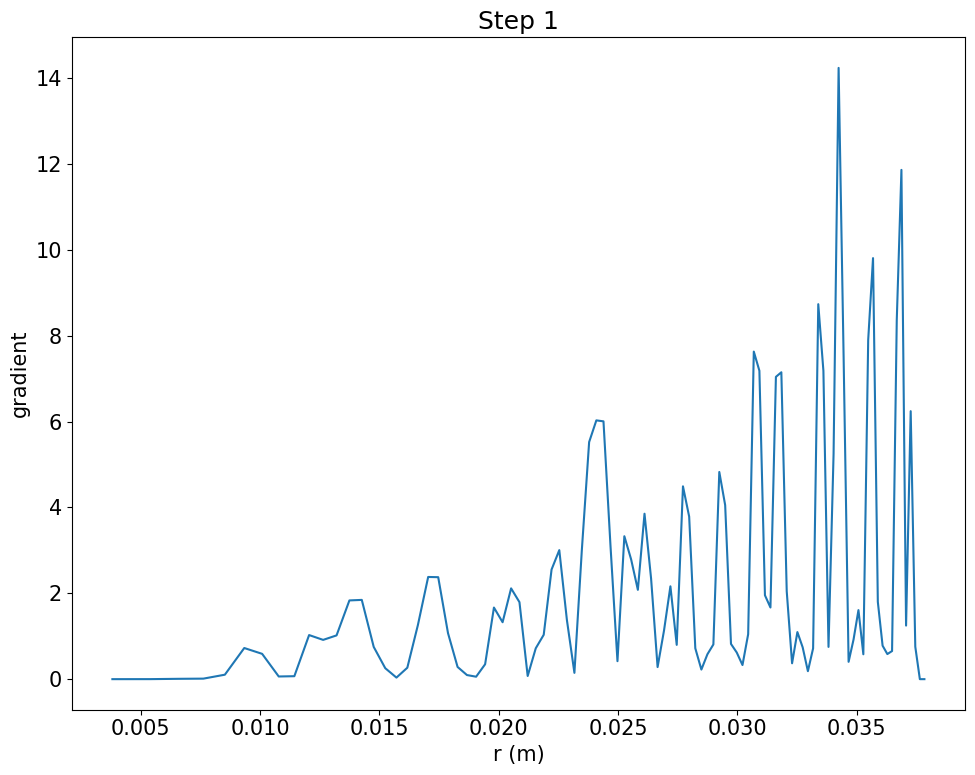

In [16]:
plt.figure(figsize=(10,8))
plt.plot(sor[1:],np.abs(g1)/5e-7)
plt.xlabel('r (m)')
plt.ylabel('gradient')
plt.tight_layout()
plt.title("Step 1")
plt.tight_layout()
plt.savefig('s1')

plt.show()